<a href="https://www.kaggle.com/code/aleksandrmorozov123/machine-learning-excercises?scriptVersionId=94663830" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


**Import required libraries**

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import (
    ensemble, 
    preprocessing, 
    tree,
)
from sklearn.metrics import (
auc,
confusion_matrix,
roc_auc_score,
roc_curve
)
from sklearn.model_selection import (
train_test_split,
)
from yellowbrick.classifier import (
ConfusionMatrix,
ROCAUC,
)
from yellowbrick.model_selection import (
LearningCurve,
)

**Read the data Titanic dataset**

In [3]:
df = pd.read_csv ('../input/titanic/train.csv')
orig_df = df

df.head (10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

**Cleaning the data**

In [4]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
import pandas_profiling
pandas_profiling.ProfileReport (df)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
df.shape

(891, 12)

In [7]:
df.describe ().iloc[:, :2]

PassengerId    Survived
count   891.000000  891.000000
mean    446.000000    0.383838
std     257.353842    0.486592
min       1.000000    0.000000
25%     223.500000    0.000000
50%     446.000000    0.000000
75%     668.500000    1.000000
max     891.000000    1.000000

In [8]:
df.isnull ().sum ()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
df.isnull ().sum (axis = 1).loc[:10]

0     1
1     0
2     1
3     0
4     1
5     2
6     0
7     1
8     1
9     1
10    0
dtype: int64

In [10]:
mask = df.isnull ().any (axis = 1)
mask.head ()  # rows

0     True
1    False
2     True
3    False
4     True
dtype: bool

In [11]:
df [mask].Embarked.head ()

0    S
2    S
4    S
5    Q
7    S
Name: Embarked, dtype: object

In [12]:
df.Sex.value_counts (dropna = False)

male      577
female    314
Name: Sex, dtype: int64

In [13]:
df.Embarked.value_counts (dropna = False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [14]:
df = df.drop (
     columns = [
         "Name",
         "Ticket",
         "Cabin"
])
df = pd.get_dummies (df)
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

**Sample data**

In [15]:
from sklearn.model_selection import train_test_split
y = df.Survived
X = df.drop (columns = "Survived")

**Impute data**

In [16]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 42)

from sklearn.experimental import enable_iterative_imputer
from sklearn import impute
num_cols = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

imputer = impute.IterativeImputer ()
imputed = imputer.fit_transform (
X_train [num_cols])
X_train.loc [:, num_cols] = imputed

meds = X_train.median ()
X_train = X_train.fillna (meds)
X_test = X_test.fillna (meds)

**Normalize data**

In [17]:
cols = "PassengerId, Pclass, Age, SibSp, Parch, Fare, Sex_female, Sex_male, Embarked_C, Embarked_Q, Embarked_S".split (",")
sca = preprocessing.StandardScaler ()
X_train = sca.fit_transform (X_train)
X_train = pd.DataFrame (X_train, columns = cols)
X_test = sca.transform (X_test)
X_test = pd.DataFrame (X_test, columns = cols)

**Refactor**

In [18]:
from sklearn.model_selection import train_test_split
def tweak_titanic (df):
    df = df.drop (
    columns = [
        "PassengerId",
        "Name",
        "Sex",
        "Age",
        "Ticket",
        "Fare",
        "Cabin",
    ]
    ).pipe (pd.get_dummies, drop_first = True)
    return df

def get_train_test_X_y (
df, y_col, size = 0.3, std_cols = None
):
    y = df [y_col]
    X = df.drop (columns = y_col)
    X_train, X_test, y_train, y_test = train_test_split (
    X, y, test_size = size, random_state = 42
    )
    cols = X.columns
    num_cols = ['Pclass', 'SibSp', 'Parch',
    'Embarked_Q', 'Embarked_S']
    fi = impute.IterativeImputer ()
    X_train.loc [
        :, num_cols
    ] = fi.fit_transform (X_train [num_cols])
    X_test.loc [:, num_cols] = fi.transform (
    X_test [num_cols])
    
    if std_cols:
        std = preprocessing.StandardScaler ()
        X_train.loc [
            :, std_cols
        ] = std.fit_transform (
        X_train [std_cols])
        
        X_test.loc [
            :, std_cols
        ] = std.transform (X_test [std_cols])
        return X_train, X_test, y_train, y_test
    
ti_df = tweak_titanic (orig_df)
std_cols = "Pclass".split (",")
X_train, X_test, y_train, y_test = get_train_test_X_y (ti_df, "Survived", std_cols = std_cols)

**Baseline model**

In [19]:
from sklearn.dummy import DummyClassifier
bm = DummyClassifier ()
bm.fit (X_train, y_train)
bm.score (X_test, y_test) # accuracy

0.585820895522388

In [20]:
from sklearn import metrics
metrics.precision_score (y_test, bm.predict (X_test))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

**K-fold cross-validation**

In [21]:
X = pd.concat ([X_train, X_test])
y = pd.concat ([y_train, y_test])
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier, 
    GaussianNB,
    SVC,
    RandomForestClassifier,
    ]:
    cls = model ()
    kfold = model_selection.KFold (n_splits=10, random_state=None)
    s = model_selection.cross_val_score (
    cls, X, y, scoring = 'roc_auc', cv = kfold)

    print (f"{model.__name__:22}   AUC: "
          f"{s.mean (): .3f} STD: {s.std(): .2f}")

DummyClassifier          AUC:  0.500 STD:  0.00
LogisticRegression       AUC:  0.717 STD:  0.05
DecisionTreeClassifier   AUC:  0.727 STD:  0.05
KNeighborsClassifier     AUC:  0.715 STD:  0.04
GaussianNB               AUC:  0.693 STD:  0.03
SVC                      AUC:  0.713 STD:  0.03
RandomForestClassifier   AUC:  0.736 STD:  0.04


**Staking**

In [22]:
from mlxtend.classifier import StackingClassifier
clfs = [
    x()
    for x in [
        LogisticRegression,
        DecisionTreeClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier
    ]
]
stack = StackingClassifier (classifiers=clfs,
                          meta_classifier = LogisticRegression ())
kfold = model_selection.KFold (n_splits = 10, random_state = None)

s = model_selection.cross_val_score (stack, X, y, scoring = 'roc_auc', cv = kfold)

print (f"{stack.__class__.__name__}  "
      f"AUC: {s.mean():.3f}  STD: {s.std():.2f}")

StackingClassifier  AUC: 0.685  STD: 0.04


**Create and evaluate Model**

In [23]:
# create model
rf = ensemble.RandomForestClassifier (n_estimators = 100, random_state = 42)
rf.fit (X_train, y_train)

# evaluate model
rf.score (X_test, y_test)

0.6940298507462687

In [24]:
# metrics precision
metrics.precision_score (y_test, rf.predict (X_test))

0.6790123456790124

In [25]:
# inspect feature performance
for col, val in sorted (zip (X_train.columns, rf.feature_importances_),
                       key = lambda x: x[1], reverse = True,
                       )[:5]:
    print (f"{col:10}{val:10.3f}")

Pclass         0.353
Parch          0.243
SibSp          0.238
Embarked_S     0.120
Embarked_Q     0.046


**Optimize model**

In [26]:
rf4 = ensemble.RandomForestClassifier ()
params = {
    "max_features": [0.4, "auto"],
    "n_estimators": [15, 200],
    "min_samples_leaf": [1, 0.1],
    "random_state": [42],
}
cv = model_selection.GridSearchCV (rf4, params, n_jobs=-1
                                  ).fit(X_train, y_train)
print (cv.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}


In [27]:
rf5 = ensemble.RandomForestClassifier (
**{
    "max_features": "auto",
    "min_samples_leaf": 0.1,
    "n_estimators": 200,
    "random_state": 42,
})
rf5.fit (X_train, y_train)

rf5.score (X_test, y_test)

0.6492537313432836

**Confusion matrix**

In [28]:
from sklearn.metrics import confusion_matrix
y_pred = rf5.predict (X_test)
confusion_matrix (y_test, y_pred)

array([[145,  12],
       [ 82,  29]])

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


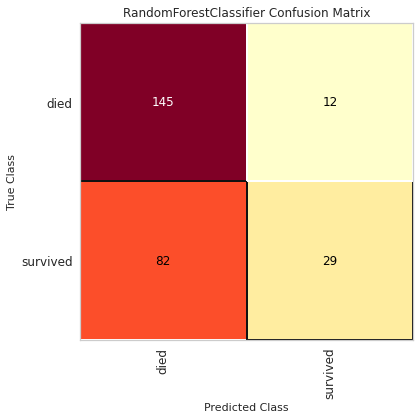

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [29]:
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots (figsize = (6, 6))
cm_viz = ConfusionMatrix (rf5, classes = ["died", "survived"],
                         label_encoder = mapping)
cm_viz.score (X_test, y_test)
cm_viz.poof ()

**ROC Curve**

In [30]:
y_pred = rf5.predict (X_test)
roc_auc_score (y_test, y_pred)

0.5924140701210765

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


AttributeError: 'RandomForestClassifier' object has no attribute 'target_type_'

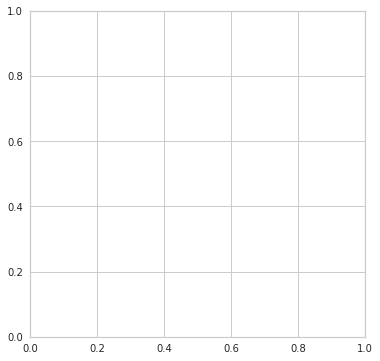

In [31]:
from yellowbrick.classifier import ConfusionMatrix, ROCAUC
fig, ax = plt.subplots (figsize = (6, 6))
roc_viz = ROCAUC (rf5)
roc_viz.score (X_test, y_test)
roc_viz.poof ()

**Learning curve**

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

fig, ax = plt.subplots (figsize = (6, 4))
cv = StratifiedKFold (12)
sizes = np.linspace (0.3, 1.0, 10)
lc_viz = LearningCurve (
rf5, 
cv = cv,
train_sizes = sizes,
scoring = "f1_weighted",
n_jobs = 4,
ax = ax)

lc_viz.fit (X, y)
lc_viz.poof ()

**Deploing model**

In [ ]:
import pickle
pic = pickle.dumps (rf5)
rf6 = pickle.loads (pic)
y_pred = rf6.predict (X_test)
roc_auc_score (y_test, y_pred)

# **The model did not show the most optimal result, so let's start all over again and carefully work through each step of titanic dataset**

**Examining missing data**

In [ ]:
df.isnull ().mean () * 100

**Using missingno library**

In [ ]:
import missingno as msno
ax = msno.matrix (df.sample (500))

**Bar plot**

In [ ]:
fig, ax = plt.subplots (figsize = (6, 4))
(df.isnull().mean().abs().plot.bar (ax=ax))

**Missingno library bar plot**

In [ ]:
ax = msno.bar (df.sample (500))

**Create a heatmap**

In [ ]:
ax = msno.heatmap (df, figsize = (6, 6))

**Create a dendrogram**

In [ ]:
ax = msno.dendrogram (df)

**Dropping missnig data**

In [ ]:
df1 = orig_df.dropna ()
df1 = orig_df.drop (columns = "Cabin")
df1 = orig_df.dropna (axis = 1)

**Imputing data**

In [ ]:
from sklearn.impute import SimpleImputer 
num_cols = df.select_dtypes (include = "number").columns
im = SimpleImputer ()  # mean
imputed = im.fit_transform (df[num_cols])

**Adding indicator columns**

In [ ]:
def add_indicator (col):
    def wrapper (df):
        return df[col].isna().astype (int)
    
    return wrapper

df1 = df.assign (cabin_missing = add_indicator ("Cabin"))

**Exploring data**

In [ ]:
df.shape 

In [ ]:
df.describe ().iloc [:, [0, -1]]

In [ ]:
df.iloc [[1, 4], -3:]

In [ ]:
df.loc [[101, 417], "Embarked":]

In [ ]:
df.head (5)

**Histogram**

In [ ]:
fig, ax = plt.subplots (figsize = (6, 4))
df.Fare.plot (kind ="hist", ax=ax)

In [ ]:
import seaborn as sns
fig, ax = plt.subplots (figsize = (12, 8))
mask = y_train == 1
ax = sns.histplot (X_train [mask].Parch, label = 'Survived')
ax = sns.histplot (X_train [~mask].Parch, label = 'Died')
ax.set_xlim(-1.5, 1.5)
ax.legend ()

**Scatter plot**

In [ ]:
fig, ax = plt.subplots (figsize= (6, 4))
df.plot.scatter (x = "Age", y = "Fare", ax = ax, alpha = 0.3)

In [ ]:
df.Parch.corr (df.Age)

**Joint plot**

In [ ]:
from yellowbrick.features import JointPlotVisualizer

fig, ax = plt.subplots (figsize = (6, 6))
jpv = JointPlotVisualizer (feature = "Pclass", target = "SibSp")
jpv.fit (df["Pclass"], df["SibSp"])
jpv.poof ()

In [ ]:
# use seaborn library to create a joint plot
from seaborn import jointplot
fig, ax = plt.subplots (figsize = (6, 6))
new_df = df.copy ()
new_df = df.copy ()
new_df["target"] = y
p = jointplot ("Pclass", "Parch", data = new_df, kind = "reg")

**Pair grid**

In [ ]:
from seaborn import pairplot
fig, ax = plt.subplots(figsize = (6, 6))
new_df = df.copy ()
new_df ["target"] = y
vars = ["Pclass", "Fare", "Age"]
p = pairplot (new_df, vars = vars, hue = "target", kind = "reg")

**Box and violin plots**

In [ ]:
from seaborn import boxplot
fig, ax = plt.subplots (figsize = (8, 6))
new_df = df.copy ()
new_df ["target"] = y
boxplot (x = "target", y = "Age", data= new_df)

In [ ]:
from seaborn import violinplot
fig, ax= plt.subplots (figsize = (8, 6))
new_df = df.copy ()
new_df ["target"] = y
violinplot (x = "target", y = "Age", data = new_df)

**Comparing two ordinal values**

In [ ]:
fig, ax = plt.subplots (figsize = (8, 6))
(df.assign (age_bin = pd.qcut (df.Age, q = 10, labels = False),
          class_bin = pd.cut (df.Pclass, bins = 3, labels = False),
          ).pipe (lambda df: pd.crosstab (df.age_bin, df.class_bin))
 .pipe (lambda df: df.div (df.sum (1), axis = 0))
 .plot.bar (stacked = True,
           width = 1,
           ax = ax,
           cmap = 'viridis',
           )
 .legend (bbox_to_anchor = (1, 1)))

**Correlation**

In [ ]:
from yellowbrick.features import Rank2D
fig, ax = plt.subplots (figsize = (6, 6))
pcv = Rank2D (features = X.columns, algorithm = "pearson")
pcv.fit (X, y)
pcv.transform (X)
pcv.poof ()

In [ ]:
from seaborn import heatmap
fig, ax = plt.subplots (figsize = (8, 8))
ax = heatmap (
X.corr (),
fmt = ".2f",
annot = True,
ax = ax,
cmap = "RdBu_r",
vmin = -1,
vmax = 1)

In [ ]:
df.corr ().iloc [:, :2]

In [ ]:
def correlated_columns (df, threshold = 0.95):
    return (df.corr ().pipe (
    lambda df1: pd.DataFrame (np.tril (df1, k=-1),
                             columns = df.columns,
                             index = df.columns)).stack ()
           .rename ("pearson").pipe (lambda s: s [
               s.abs () > threshold].reset_index ())
           .query ("level_0 not in level_1"))

correlated_columns (df)

**RadViz**

In [ ]:
from yellowbrick.features import RadViz
fig, ax = plt.subplots (figsize = (6, 6))
rv = RadViz (classes = ["died", "survived"],
            features = X.columns)
rv.fit (X, y)
_ = rv.transform (X)
rv.poof ()

In [ ]:
# pandas library can plot RadViz
from pandas.plotting import radviz
fig, ax = plt.subplots (figsize = (6, 6))
new_df = X.copy ()
new_df ["target"] = y
radviz (new_df, "target", ax = ax, colormap = "PiYG")

**Parallel coordinates**

In [ ]:
from yellowbrick.features import ParallelCoordinates
fig, ax = plt.subplots (figsize = (6, 4))
pc = ParallelCoordinates (classes = ["died", "survived"],
                         features = X.columns)
pc.fit (X, y)
pc.transform (X)
ax.set_xticklabels (ax.get_xticklabels (), rotation = 45)
pc.poof ()

In [ ]:
# pandas library can plot parallel coordinates
from pandas.plotting import parallel_coordinates
fig, ax = plt.subplots (figsize = (6, 4))
new_df = X.copy ()
new_df ["target"] = y
parallel_coordinates (new_df, "target", ax = ax, colormap = "viridis", alpha = 0.5)
ax.set_xticklabels (ax.get_xticklabels (), rotation = 45)

**Standardize data**

In [ ]:
from sklearn import preprocessing
X2 = df
std = preprocessing.StandardScaler ()
std.fit_transform (X)

In [ ]:
std.scale_

In [ ]:
std.mean_

In [ ]:
std.var_

In [ ]:
X_std = (X2 - X2.mean ()) / X2.std ()
X_std

In [ ]:
X_std.mean ()

In [ ]:
X_std.std ()

**Scale to range**

In [ ]:
from sklearn import preprocessing
mms = preprocessing.MinMaxScaler ()
mms.fit (X2)
mms.transform (X2)

In [ ]:
# pandas preprocessing
(X2 - X2.min ()) / (X2.max () - X2.min ())

**Dummy variables**

In [ ]:
pd.get_dummies (df, drop_first = True)

**Label encoder**

In [ ]:
df1 = pd.read_csv ('../input/titanic/train.csv')
df1.head (5)

In [ ]:
from sklearn import preprocessing
lab = preprocessing.LabelEncoder ()
lab.fit_transform (df1.Name)

In [ ]:
lab.inverse_transform ([1, 1, 0])

In [ ]:
df1.Name.astype ("category").cat.as_ordered ().cat.codes + 1


**Frequency encoding**

In [ ]:
from collections import Counter
c = Counter ()
def triples (val):
    for i in range (len(val)):
        c[val[i : i + 3]] += 1
df1.Name.apply (triples)
c.most_common (10)

In [ ]:
df1.Name.str.extract ("([A-Za-z]+)\.", expand = False).head ()

In [ ]:
df1.Name.str.extract ("([A-Za-z]+)\.", expand = False).value_counts ()

**Other categorical encoding**

In [ ]:
import category_encoders as ce
he = ce.HashingEncoder (verbose = 1)
he.fit_transform (df1)

**Manual feature engineering**

In [ ]:
agg = (df.groupby ("Embarked_Q").agg ("min, max, mean, sum".split (","))
      .reset_index ())
agg.columns = ["_".join (c).strip("_")
              for c in agg.columns.values]
agg_df = df1.merge (agg, on = "Embarked_Q")

**Feature selection - Collinear columns**

In [ ]:
limit = 0.95
corr = df.corr ()
mask = np.triu (np.ones (corr.shape), k = 1).astype (bool)
corr_no_diag = corr.where (mask)
coll = [c
       for c in corr_no_diag.columns
       if any (abs (corr_no_diag [c]) > threshold)]
coll

In [ ]:
rfimp.plot_dependence_heatmap (rfpimp.feature_dependence_matrix (X_train),
                              value_fontsize = 12,
                              label_fontsize = 14,
                              figsize = (8, 8))
fig = plt.gcf ()

In [ ]:
cols_to_remove = [
    "Pclass",
    "SibSp",
    "Parch",
    "Embarked_Q"
]
rf3 = RandomForestClassifier (random_state = 42)
rf3.fit (X_train [[c for c in X_train.columns
                 if c not in cols_to_remove]], y_train)
rf3.score (X_test [[c for c in X_train.columns
                   if c not in cols_to_remove]], y_test)

In [ ]:
rf4 = RandomForestClassifier (random_state = 42)
rf4.fit (X_train, y_train)
rf4.score (X_test, y_test)

**Lasso regression**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsCV
model = make_pipeline (StandardScaler (with_mean = False), LassoLarsCV (cv = 10, max_n_alphas = 10))
model.fit (X_train, y_train)

for i in range (X.shape [1]):
    ax.plot (
    label = X.columns [i])
    
ax.axvline (
           linestyle = "-",
           c = "k",
           label = "alphaCV")
plt.ylabel ("Regression Coefficients")
ax.legend (X.columns, bbox_to_anchor = (1, 1))
plt.xlabel ("alpha")
plt.title ("Regression Coefficients Progression for Lasso Paths")

**Recursive feature elimination**

In [ ]:
from yellowbrick.features import RFECV
fig, ax = plt.subplots (figsize = (6, 4))
rfe = RFECV (ensemble.RandomForestClassifier (n_estimators = 100), cv = 5)
rfe.fit (X, y)

rfe.rfe_estimator_.ranking_

rfe.rfe_estimator_.n_features_

rfe.rfe_estimator_.support_

rfe.poof ()

In [ ]:
# find the 10 most important features
from sklearn.feature_selection import RFE
model = ensemble.RandomForestClassifier (n_estimators = 100)
rfe = RFE (model, 3)
rfe.fit (X, y)
agg_X.columns [rfe.support_]

**Mutual information between feature and target**

In [ ]:
from sklearn import feature_selection
mic = feature_selection.mutual_info_classif (X, y)
fig, ax = plt.subplots (figsize = (10, 8))
(pd.DataFrame ({"feature":X.columns, "vimp": mic}).set_index ("feature").plot.barh (ax = ax))

**Unsampling minority**

In [ ]:
from sklearn.utils import resample
mask = df.Survived == 1
surv_df = df [mask]
death_df = df[~mask]
df_usample = resample (surv_df, replace = True, n_samples = len (death_df), random_state = 42)
df2 = pd.concat ([death_df, df_usample])
df2.Survived.value_counts ()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler (random_state = 42)
X_ros, y_ros = ros.fit_sample (X, y)
pd.Series (y_ros).value_counts ()

**Downsampling majority**

In [ ]:
from sklearn.utils import resample
mask = df.Survived == 1
surv_df = df [mask]
death_df = df[~mask]
df_downsample = resample (death_df, replace = False, n_samples = len (surv_df), random_state = 42)
df3 = pd.concat ([surv_df, df_downsample])
df3.Survived.value_counts ()

**Logistic regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression (random_state = 42)
lr.fit (X_train, y_train)
lr.score (X_test, y_test)

In [ ]:
lr.predict_proba (X.iloc [[1]])

In [ ]:
lr.predict_log_proba (X.iloc [[2]])

In [ ]:
lr.decision_function (X.iloc [[3]])

In [ ]:
lr.intercept_

In [ ]:
def inv_logit (p):
    return np.exp (p) / (1 + np.exp (p))

inv_logit (lr.intercept_)

In [ ]:
# inspect the coefficients

cols = X.columns
for col, val in sorted (zip (cols, lr.coef_[0]), key = lambda x: x[1], reverse = True):
    print (f"{col:10}{val:10.3f} {inv_logit (val):10.3f}")

In [ ]:
# inspect coefficients with yellowbrick

from yellowbrick.model_selection import FeatureImportances
fig, ax = plt.subplots (figsize = (6, 4))
fi_viz = FeatureImportances (lr)
fi_viz.fit (X, y)
fi_viz.poof ()

**Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB ()
nb.fit (X_train, y_train)
nb.score (X_test, y_test)

In [ ]:
nb.predict_proba (X.iloc [[1]])

In [ ]:
nb.predict_log_proba (X.iloc [[2]])

**Support vector machine (SVM)**

In [ ]:
# scikit-learn's SVM implementation

from sklearn.svm import SVC
svc = SVC (random_state = 42, probability = True)
svc.fit (X_train, y_train)
svc.score (X_test, y_test)

In [ ]:
svc.predict_proba (X.iloc [[2]])

In [ ]:
svc.predict_log_proba (X.iloc [[3]])

**K-Nearest Neighbor**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier ()
knc.fit (X_train, y_train)
knc.score (X_test, y_test)

In [ ]:
knc.predict_proba (X.iloc [[1]])

**Decision Tree**

In [52]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier (random_state = 42, max_depth = 3)
dt.fit (X_train, y_train)
dt.score (X_test, y_test)

0.6828358208955224

In [53]:
dt.predict_proba (X.iloc [[1]])

array([[0.79835391, 0.20164609]])

In [55]:
dt.predict_proba (X.iloc [[2]])

array([[0.79835391, 0.20164609]])

In [56]:
dt.predict_log_proba (X.iloc [[3]])

array([[-1.32913595, -0.3074847 ]])

In [57]:
# feature importance

for col, val in sorted (
    zip (X.columns, dt.feature_importances_),
    key = lambda x: x[1],reverse = True) [:5]:
    print (f"{col:10}{val:10.3f}") 

Pclass         0.562
Embarked_S     0.240
Parch          0.155
SibSp          0.043
Embarked_Q     0.000


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


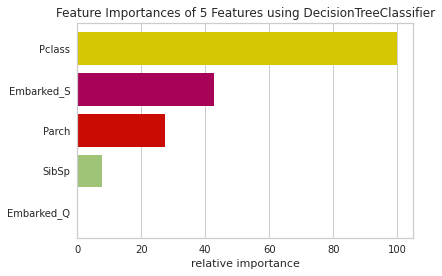

<AxesSubplot:title={'center':'Feature Importances of 5 Features using DecisionTreeClassifier'}, xlabel='relative importance'>

In [58]:
# feature importance

from yellowbrick.model_selection import FeatureImportances
fig, ax = plt.subplots (figsize = (6, 4))
fi_viz = FeatureImportances (dt)
fi_viz.fit (X, y)
fi_viz.poof ()

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier (random_state = 42)
rf.fit (X_train, y_train)

rf.score (X_test, y_test)

In [ ]:
rf.predict_proba (X.iloc [[1]])

In [ ]:
rf.predict_log_proba (X.iloc [[1]])

In [ ]:
# feature importance
for col, val in sorted (zip (X.columns, rf.feature_importances_),
                       key = lambda x: x[1], reverse = True) [:5]:
    print (f"{col:10}{val:10.3f}")

**XGBoost**

In [ ]:
import xgboost as xgb
xgb_class = xgb.XGBClassifier (random_state = 42, use_label_encoder=False) 
xgb_class.fit (X_train, y_train, early_stopping_rounds = 10, eval_set = [(X_test, y_test)])

xgb_class.score (X_test, y_test)

In [ ]:
xgb_class.predict_proba (X.iloc [[1]])

In [ ]:
# feature importance
for col, val in sorted (zip (X.columns, xgb_class.feature_importances_), key = lambda x: x[1],
                       reverse = True)[:5]:
    print (f"{col:10}{val:10.3f}")

In [ ]:
fig, ax = plt.subplots (figsize = (6, 4))
xgb.plot_importance (xgb_class, ax = ax)

In [ ]:
fig, ax = plt.subplots (figsize = (6, 4))
fi_viz = FeatureImportances (xgb_class)
fi_viz.fit (X, y)
fi_viz.poof ()

In [ ]:
# text representation of the trees

booster = xgb_class.get_booster ()
print (booster.get_dump () [0])

In [ ]:
# score from first tree leaf 7
1 / (1 + np.exp (- 1 * 0.1535))

In [ ]:
# graphical version tree model

fig, ax = plt.subplots (figsize = (16, 12))
xgb.plot_tree (xgb_class, ax = ax, num_trees = 0)

**Gradient Boosted with LightGBM**

In [ ]:
import lightgbm as lgb
lgbm_class =lgb.LGBMClassifier (random_state = 42)
lgbm_class.fit (X_train, y_train)

lgbm_class.score (X_test, y_test)

In [ ]:
lgbm_class.predict_proba (X.iloc [[1]])

In [ ]:
lgbm_class.predict_proba (X.iloc[[2]])

In [ ]:
# feature importance based on 'splits'

for col, val in sorted (zip (cols, lgbm_class.feature_importances_),
                       key = lambda x: x[1], reverse = True)[:5]:
    print (f"{col:10}{val:10.3f}")

In [ ]:
fig, ax = plt.subplots (figsize = (6, 4))
lgb.plot_importance (lgbm_class, ax = ax)
fig.tight_layout ()

In [ ]:
fig, ax = plt.subplots (figsize = (16, 12))
lgb.plot_tree (lgbm_class, tree_index = 0, ax = ax)

**TPOT**

In [46]:
from tpot import TPOTClassifier
tc = TPOTClassifier (generations = 2)
tc.fit (X_train, y_train)
tc.score (X_test, y_test)

0.7089552238805971

In [51]:
tc.predict_proba (X.iloc [[1]])

array([[0.81067049, 0.18932951]])

**Learning Curve**

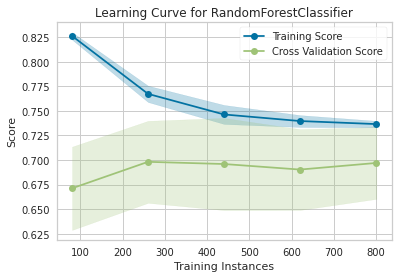

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [34]:
from yellowbrick.model_selection import LearningCurve
fig, ax = plt.subplots (figsize = (6, 4))
lc3_viz = LearningCurve (RandomForestClassifier (n_estimators = 100), cv = 10)
lc3_viz.fit (X, y)
lc3_viz.poof ()

**Validation Curve**

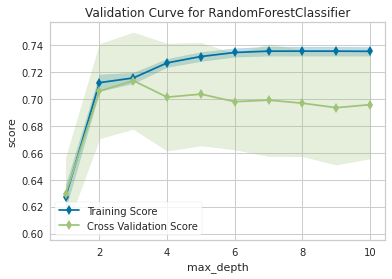

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>

In [32]:
from yellowbrick.model_selection import ValidationCurve
fig, ax = plt.subplots (figsize = (6, 4))
vc_viz = ValidationCurve (RandomForestClassifier (n_estimators = 100),
                         param_name = "max_depth", param_range = np.arange (1, 11),
                          cv = 10, n_jobs = -1)
vc_viz.fit (X, y)
vc_viz.poof()

**Confusion matrix**

In [60]:
y_predict = dt.predict (X_test)
tp = ((y_test == 1) & (y_test == y_predict)).sum () # 123
tn = ((y_test == 0) & (y_test == y_predict)).sum () # 199
fp = ((y_test == 0) & (y_test != y_predict)).sum () # 25
fn = ((y_test == 1) & (y_test != y_predict)).sum () # 46

In [62]:
from sklearn.metrics import confusion_matrix
y_predict = dt.predict (X_test)
pd.DataFrame (confusion_matrix (y_test, y_predict), columns = ["Predict died", "Predict Survive"],
             index = ["True Death", "True Survive"])

Predict died  Predict Survive
True Death             139               18
True Survive            67               44

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


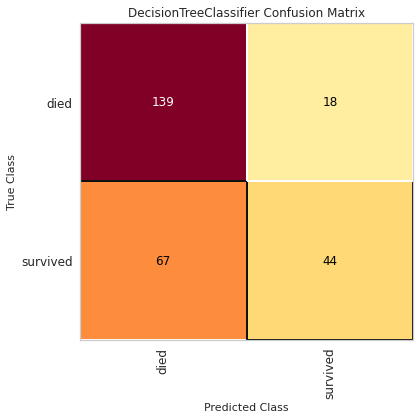

<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [63]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import ConfusionMatrix
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots (figsize = (6, 6))
cm_viz = ConfusionMatrix (dt, classes = ["died", "survived"],
                         label_encoder = mapping)
cm_viz.score (X_test, y_test)
cm_viz.poof ()